In [86]:
import os
import sys
from haystack import Pipeline, Document, component
from haystack.utils import Secret
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.generators.llama_cpp import LlamaCppGenerator
from typing import List

For now, use a dummy document store

For production environments we'd probably use a vector database and process our source documents ahead of time.

In [87]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

document_store = InMemoryDocumentStore()

docs = [
    Document(content="The 'Slacker 9000' is for people who like to wear a casual trainer that also looks good. It's water resistant and durable but unsuitable for job interviews."), 
    Document(content="The 'Red Rocket' is a superior choice in evening wear for ladies, available in all common sizes. It is not at all water resistant and should be kept dry at all times."), 
    Document(content="The 'Business Black' is a standard office shoe for men who work in banking and similar office-based jobs. It's dull but durable and totally waterproof.")
]

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

docs_with_embeddings = doc_embedder.run(docs)

#Write embedded documents to store.
document_store.write_documents(docs_with_embeddings["documents"])

#x = document_store.count_documents()
#print(x)

retriever = InMemoryEmbeddingRetriever(document_store)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 35.33it/s]


In [88]:
generator = LlamaCppGenerator(
    model="models/llama-2-7b-chat.Q5_K_S.gguf", 
    n_ctx=512,
    n_batch=128,
    model_kwargs={"n_gpu_layers": -1},
		generation_kwargs={"max_tokens": 128, "temperature": 0.1},
)
print("LLM STARTING, Please wait...")
generator.warm_up()
print("LLM READY.")

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from models/llama-2-7b-chat.Q5_K_S.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32         

LLM STARTING, Please wait...


llm_load_tensors:        CPU buffer size =  4435.49 MiB
..................................................................................................
llama_new_context_with_model: n_ctx      = 512
llama_new_context_with_model: n_batch    = 128
llama_new_context_with_model: n_ubatch   = 128
llama_new_context_with_model: flash_attn = 0
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_kv_cache_init:        CPU KV buffer size =   256.00 MiB
llama_new_context_with_model: KV self size  =  256.00 MiB, K (f16):  128.00 MiB, V (f16):  128.00 MiB
llama_new_context_with_model:        CPU  output buffer size =     0.12 MiB
llama_new_context_with_model:        CPU compute buffer size =    17.63 MiB
llama_new_context_with_model: graph nodes  = 1030
llama_new_context_with_model: graph splits = 1


LLM READY.


AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | AVX512_BF16 = 0 | FMA = 1 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 0 | 
Model metadata: {'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.eos_token_id': '2', 'general.architecture': 'llama', 'llama.context_length': '4096', 'general.name': 'LLaMA v2', 'llama.embedding_length': '4096', 'llama.feed_forward_length': '11008', 'llama.attention.layer_norm_rms_epsilon': '0.000001', 'llama.rope.dimension_count': '128', 'llama.attention.head_count': '32', 'tokenizer.ggml.bos_token_id': '1', 'llama.block_count': '32', 'llama.attention.head_count_kv': '32', 'general.quantization_version': '2', 'tokenizer.ggml.model': 'llama', 'general.file_type': '16'}
Using fallback chat format: llama-2


In [89]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

# For embedding the user query.
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")


In [90]:
from haystack.components.builders import PromptBuilder

template = """
You are a freindly and helpful shoe store assistant for an online shoe store called 'Shoes are us'.
You are only here to provide answers to questions about our products. Do not offer to interact with anything like shopping carts or to check stock.
Do not role-play, add silly actions or unnecessary chatter to your response.
Keep it polite but concise. Keep responses to one or two sentences only.
Do you best to answer using the context provided below (call this your 'store records') but if you cannot answer the question given the context supplied,
do not invent content, instead suggest that they email the store to ask a human.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)


In [91]:
from haystack import Pipeline

basic_rag_pipeline = Pipeline()
# Add components to your pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")


🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: LlamaCppGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

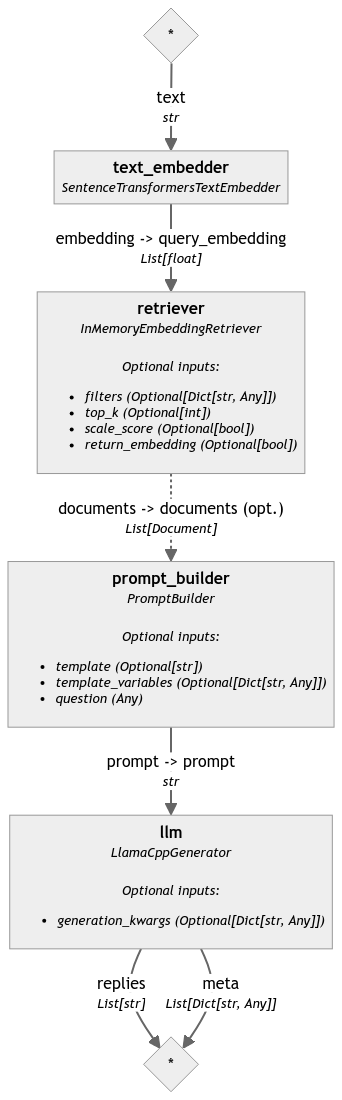

In [92]:
basic_rag_pipeline.show()

In [93]:
# Sensible on-topic questions
question = "What shoes do you sell?"
#question = "I work in a fancy office. What kind of shoes do you sell for that?"

# Off-topic - should politely decline to answer.
#question = "Do you like cheese?" 
#question = "What kind of cat is suitable for someone with an allergy to cat dander?"


response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.07it/s]

llama_print_timings:        load time =    6588.58 ms
llama_print_timings:      sample time =      10.70 ms /    35 runs   (    0.31 ms per token,  3271.95 tokens per second)
llama_print_timings: prompt eval time =   15765.47 ms /   298 tokens (   52.90 ms per token,    18.90 tokens per second)
llama_print_timings:        eval time =    5367.39 ms /    34 runs   (  157.86 ms per token,     6.33 tokens per second)
llama_print_timings:       total time =   21160.11 ms /   332 tokens


 We sell the Business Black, Red Rocket, and Slacker 9000 shoes. Would you like to know more about any of these products?
